# Kaggle_bike rental regression

https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

1. datetime - hourly date + timestamp  
2. season 
- 1 = spring
- 2 = summer
- 3 = fall
- 4 = winter 
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals(label)

아이디어
- 풍속이 0인 것을 모델링을 통해 예측
- 카테고리형 데이터 원핫 인코딩
- count변수 정규화
- 이상치: weather==4일때의 이상치

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sampleSubmission.csv')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 결측치 없음
- datetime 변환 필요해 보임 (object -> datetime)
- 나머지는 다 정수/실수형
- 각자 이상치 확인할 것

## Datetime Preprocessing

In [30]:
# datetime

tr_n = train.copy()
tr_n.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [31]:
tr_n.datetime = pd.to_datetime(tr_n.datetime)
tr_n.datetime.astype

<bound method NDFrame.astype of 0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]>

In [32]:
tr_n['year']=tr_n.datetime.dt.year
tr_n['month']=tr_n.datetime.dt.month
tr_n['day']=tr_n.datetime.dt.day
tr_n['hour']=tr_n.datetime.dt.hour
tr_n['min']=tr_n.datetime.dt.minute
tr_n['second']=tr_n.datetime.dt.second

In [33]:
tr_n.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,min,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


In [34]:
print(tr_n.year.unique()) # 연도가 유의미?
print(tr_n.month.unique())
print(tr_n.day.unique())
print(tr_n.hour.unique()) 
print(tr_n['min'].unique()) # 무의미->삭제
print(tr_n.second.unique()) # 무의미->삭제

[2011 2012]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[0]
[0]


## Delete Columns
- min, second, causal, registered

In [35]:
tr_n.drop(['min','second'],axis=1, inplace=True)

In [36]:
# 중복치 없음
tr_n.duplicated().sum()

# causual, registered 삭제
tr_n.drop(['casual','registered'],axis=1, inplace=True)

In [37]:
tr_n.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,23.000000


## Visualization

<AxesSubplot:>

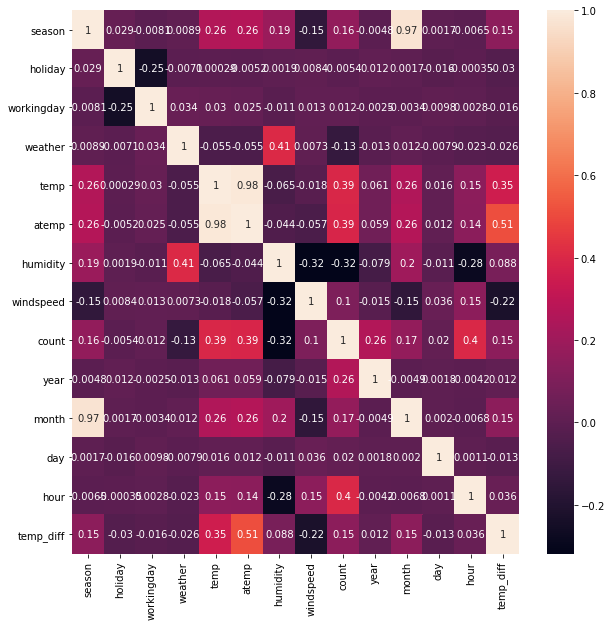

In [94]:
# 상관관계 heatmap
# 온도, 체감온도, 시간

plt.figure(figsize=(10,10))
sns.heatmap(tr_n.corr(),annot=True)

In [39]:
def draw(model,x=None,y=None,hue=None,data=tr_n,title=None,pal=None):
    plt.figure(figsize=(6,6))
    model(x=x,y=y,data=data,hue=hue,palette=pal)    
    plt.title(title)

### Year

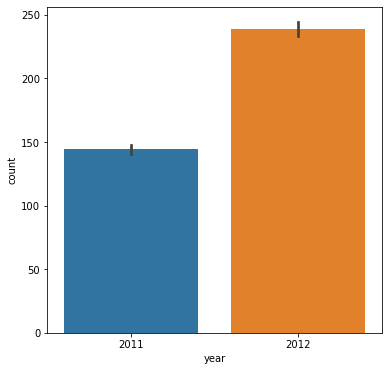

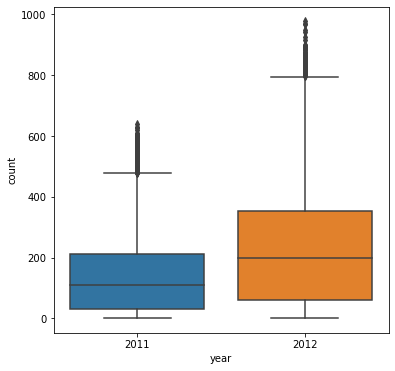

In [40]:
draw(sns.barplot,'year','count')
draw(sns.boxplot,'year','count')

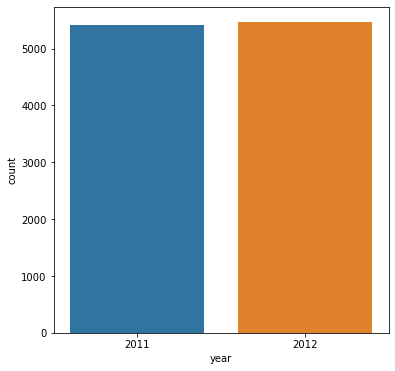

In [41]:
draw(sns.countplot,x='year')

- data 개수가 유사함에도 불구하고, 2011년보다 2012년의 대여량 수가 더 많음
- 그 이유는 자전거 대여 스테이션이 2012년에 더 확충되었기 때문
(참고 : [Capital Bike Share_history](https://www.capitalbikeshare.com/about))
- 따라서 연도 변수는 전체적인 경향성에서 영향력 O


### Month

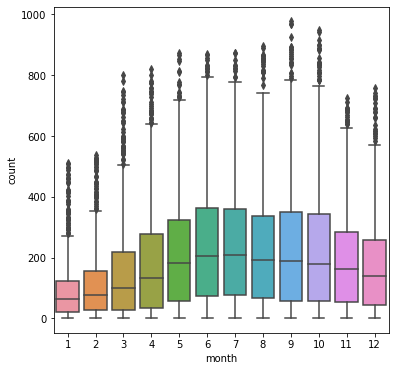

In [42]:
draw(sns.boxplot,'month','count')

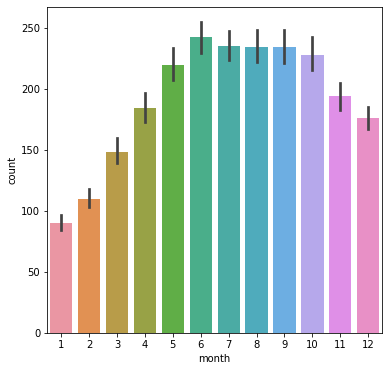

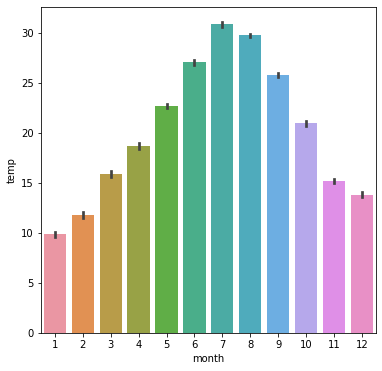

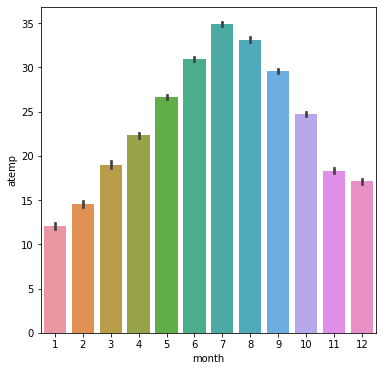

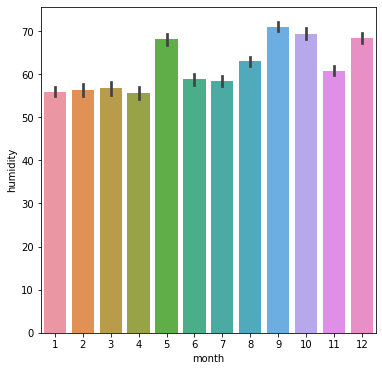

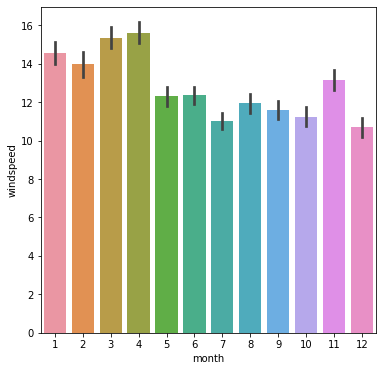

In [43]:
draw(sns.barplot,'month','count')
draw(sns.barplot,'month','temp')
draw(sns.barplot,'month','atemp')
draw(sns.barplot,'month','humidity')
draw(sns.barplot,'month','windspeed')
draw(sns.barplot,'month','weather')

- 온도와 대체적으로 경향성이 유사

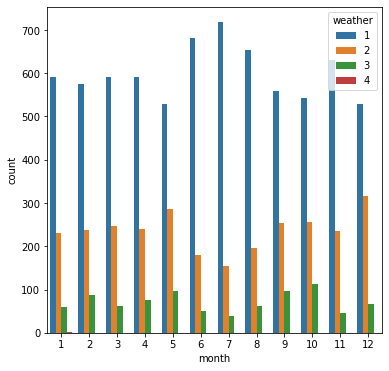

In [44]:
draw(sns.countplot,x='month',hue='weather',data=tr_n)

### Day
- 상관성이 적을 것이라 생각됨

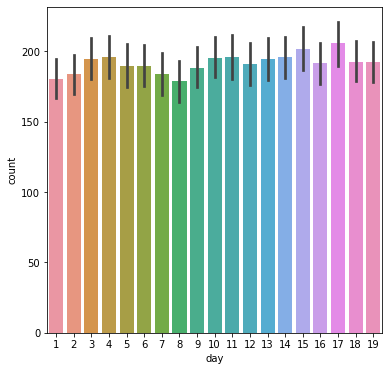

In [45]:
draw(sns.barplot, 'day','count')

### Season
- 1 = spring
- 2 = summer
- 3 = fall
- 4 = winter

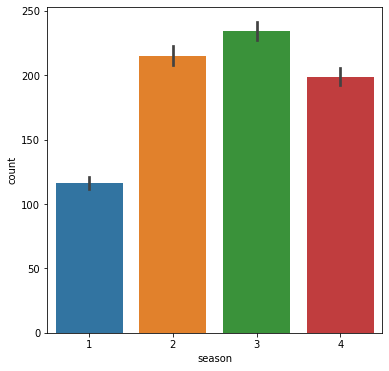

In [46]:
# 의외로 봄에 낮음
draw(sns.barplot, 'season','count')

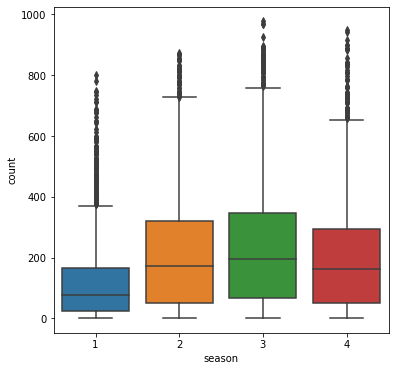

In [47]:
draw(sns.boxplot, 'season','count')

In [48]:
# 계절 구분 확인
for season in tr_n.season.unique():
    print(season,'_',tr_n.month[tr_n.season == season].unique())

1 _ [1 2 3]
2 _ [4 5 6]
3 _ [7 8 9]
4 _ [10 11 12]


### Hour

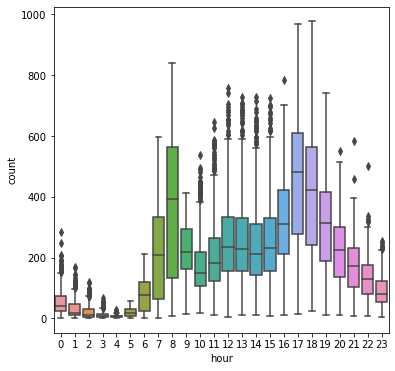

In [49]:
draw(sns.boxplot,'hour','count')

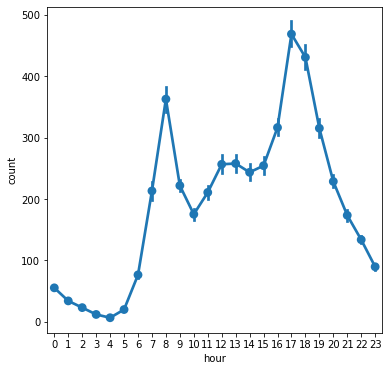

In [50]:
# 수도인 워싱턴이기 때문에, 출퇴근 시간에 가장 급증

draw(sns.pointplot,'hour','count')

#### Hour_Season

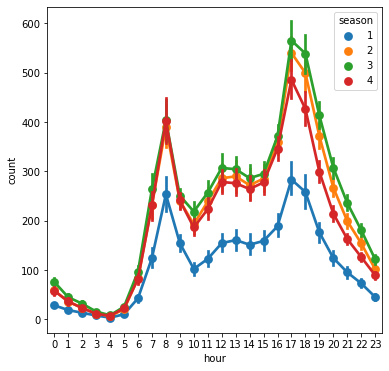

In [51]:
draw(sns.pointplot, x='hour',y='count',hue='season',pal='tab10')

- 계절간(1~3)의 차이성이 두드러지지 않음
- 성범님처럼 계절을 분화하는 것도 좋을 것 같음
- 그 분화 기준은 온도/체감온도가 되어야 할 것

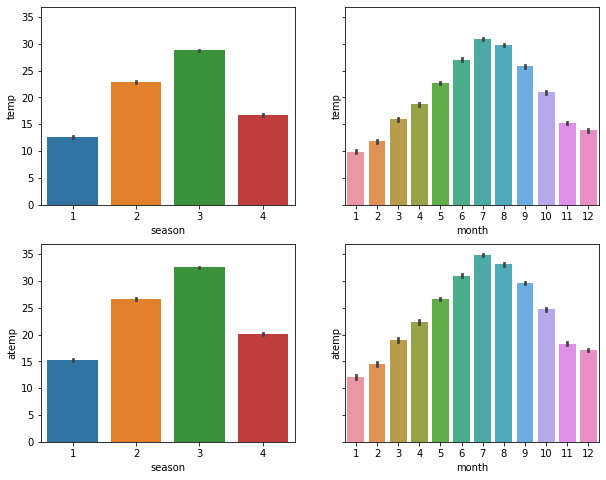

In [52]:
f, ax=plt.subplots(figsize=(10,8),ncols=2,nrows=2,sharey=True)
sns.barplot(x='season',y='temp',data=tr_n,ax=ax[0][0])
sns.barplot(x='month',y='temp',data=tr_n,ax=ax[0][1])
sns.barplot(x='season',y='atemp',data=tr_n,ax=ax[1][0])
sns.barplot(x='month',y='atemp',data=tr_n,ax=ax[1][1])
plt.show()

#### Hour_Holiday & Workingday

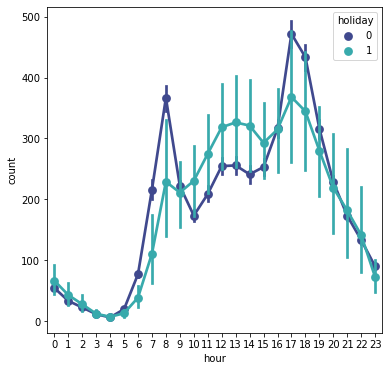

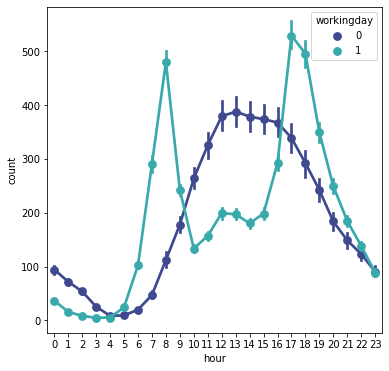

In [53]:
draw(sns.pointplot,'hour','count','holiday',pal='mako')
draw(sns.pointplot,'hour','count','workingday',pal='mako')

In [54]:
for workingday in [0,1]:
    print(workingday, '_', tr_n.holiday[tr_n.workingday==workingday].unique())

0 _ [0 1]
1 _ [0]


- 근무일이 아니고 공휴일이 아니다 = 주말
- 근무일이 아니고 공휴일이다 = 공휴일
- 근무일이며 공휴일이 아니다 = 평일(공휴일X)

workingday와 holiday를 엮어 workingday / weekend / holiday를 만들고 이 변수에 따른 영향 확인
- (workingday = 0, holiday = 0) = weekend
- (workingday = 0, holiday = 1) = holiday (기존 holiday와 같은 의미)
- (workingday = 1, holiday = 0) = workingday (기존 workingday와 같은 의미)

In [55]:
tr_n['day_div']='workingday'
tr_n.day_div[(tr_n.workingday==0)&(tr_n.holiday==0)]='weekend'
tr_n.day_div[(tr_n.workingday==0)&(tr_n.holiday==1)]='holiday'

<ipython-input-55-5d4ac004eae6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_n.day_div[(tr_n.workingday==0)&(tr_n.holiday==0)]='weekend'
<ipython-input-55-5d4ac004eae6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_n.day_div[(tr_n.workingday==0)&(tr_n.holiday==1)]='holiday'


In [56]:
tr_n.day_div.value_counts()

workingday    7412
weekend       3163
holiday        311
Name: day_div, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

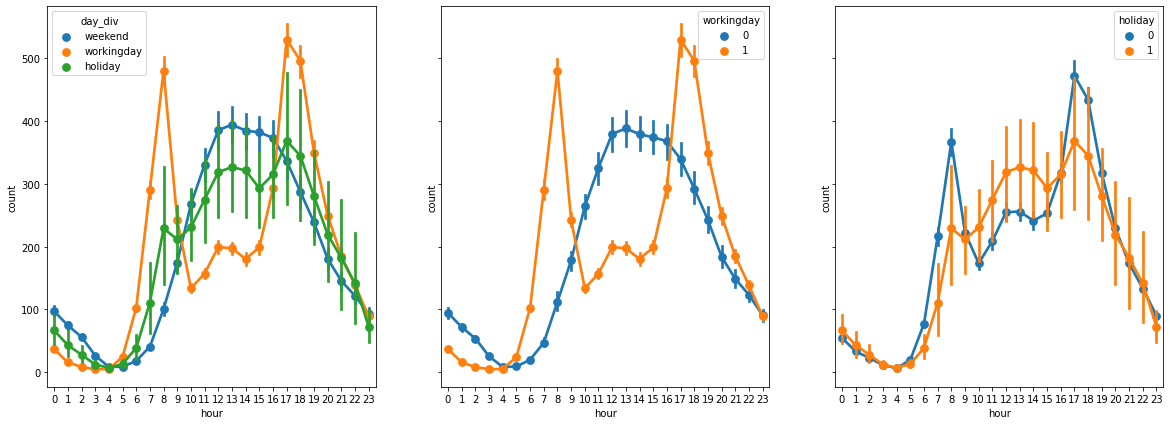

In [57]:
f, ax=plt.subplots(figsize=(20,7),ncols=3,sharey=True)
sns.pointplot(x='hour',y='count',hue='day_div',pal='tab10',data=tr_n,ax=ax[0])
sns.pointplot(x='hour',y='count',hue='workingday',pal='tab10',data=tr_n,ax=ax[1])
sns.pointplot(x='hour',y='count',hue='holiday',pal='tab10',data=tr_n,ax=ax[2])

<AxesSubplot:xlabel='hour', ylabel='count'>

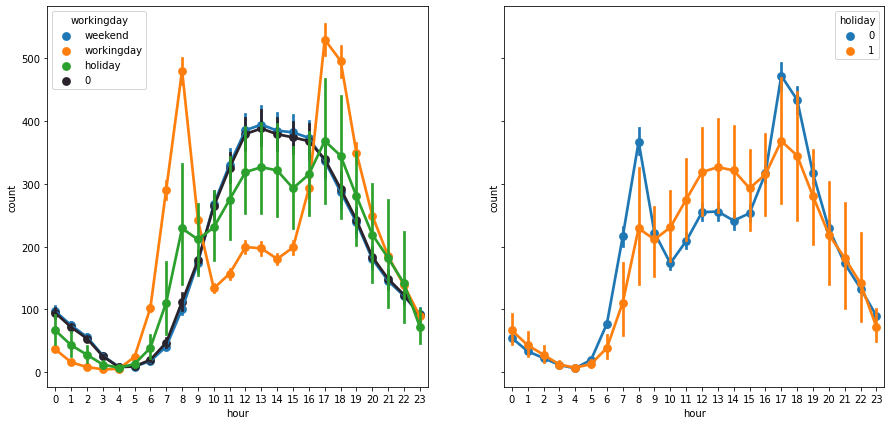

In [58]:
f, ax=plt.subplots(figsize=(15,7),ncols=2,sharey=True)
sns.pointplot(x='hour',y='count',hue='day_div',pal='tab10',data=tr_n,ax=ax[0])
sns.pointplot(x='hour',y='count',hue='workingday',data=tr_n[tr_n.workingday==0],ax=ax[0],color='purple')
sns.pointplot(x='hour',y='count',hue='holiday',pal='tab10',data=tr_n,ax=ax[1])

- 비근무일(0) 중 주말이 차지하는 비중이 커서 그런지, 비근무일의 추세와 주말의 추세와 거의 다르지 않다. 즉, 새로 만든 변수의 유효성이 거의 없다.
- 다만, workingday와 holiday 변수를 빼고 이 변수를 넣어도 나쁘지 않을 것 같다

In [59]:
tr_n['date']=tr_n.datetime.apply(lambda x:str(x).split()[0])

In [60]:
pd.DataFrame(tr_n.date[tr_n.holiday==1].unique(),columns=['holiday'])

,holiday
0,2011-01-17
1,2011-04-15
2,2011-07-04
3,2011-09-05
4,2011-10-10
5,2011-11-11
6,2012-01-02
7,2012-01-16
8,2012-04-16
9,2012-07-04


- 2011.01.01은 토요일이어서 주말로 처리
- 2012.01.01은 일요일이어서 주말로 처리, 그리고 대체공휴일로 2012.01.02때 쉼
- 2011.04.15, 2012.04.16은 무슨 날? 공식 공휴일에 없음
* 참고: [미국 공식 공휴일](https://www.calendarpedia.com/holidays/federal-holidays-2011.html)


- **시각화로 해당날짜의 특이성 여부를 파악**

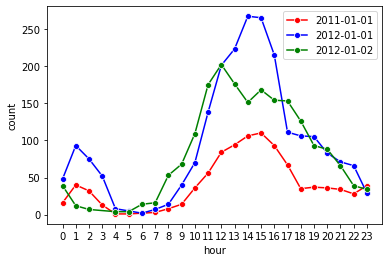

In [61]:
sns.lineplot(x='hour',y='count',data=tr_n[tr_n.date=='2011-01-01'],color='red',label='2011-01-01',marker='o')
sns.lineplot(x='hour',y='count',data=tr_n[tr_n.date=='2012-01-01'],color='blue',label='2012-01-01',marker='o')
sns.lineplot(x='hour',y='count',data=tr_n[tr_n.date=='2012-01-02'],color='green',label='2012-01-02',marker='o')
plt.xticks(tr_n.hour.unique())
plt.show()

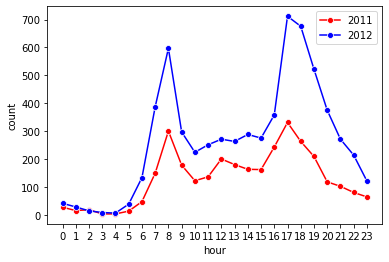

In [62]:
sns.lineplot(x='hour',y='count',data=tr_n[tr_n.date=='2011-04-15'],color='red',label=2011,marker='o')
sns.lineplot(x='hour',y='count',data=tr_n[tr_n.date=='2012-04-16'],color='blue',label=2012,marker='o')
plt.xticks(tr_n.hour.unique())
plt.show()

- 2011.04.15와 2012.04.16은 오히려 **평일**에 가까운 추이를 보임

#### Hour_weather

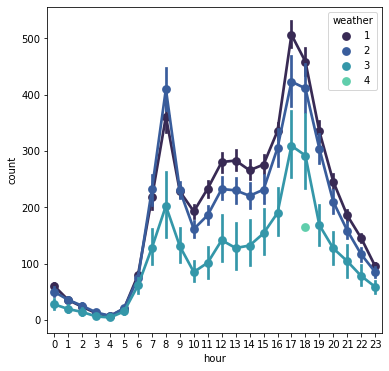

In [63]:
draw(sns.pointplot, 'hour','count','weather',pal='mako')

In [64]:
tr_n[tr_n.weather==4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,day_div,date
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,164,2012,1,9,18,workingday,2012-01-09


### Holiday & Workingday

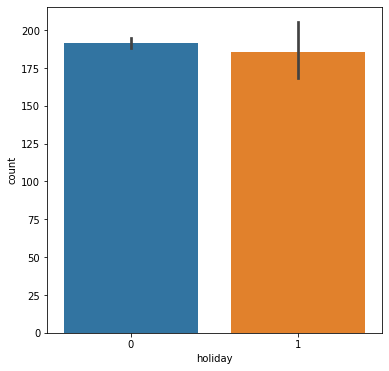

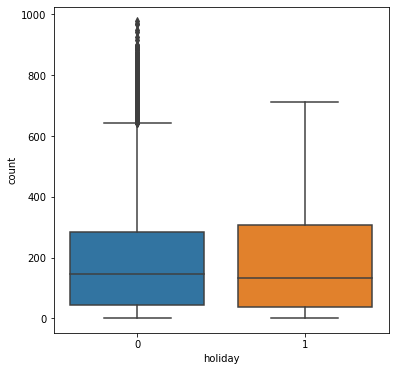

In [65]:
draw(sns.barplot, 'holiday','count')
draw(sns.boxplot, 'holiday','count')

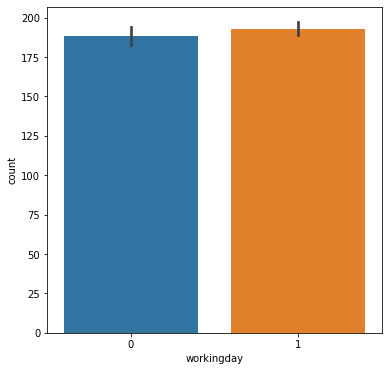

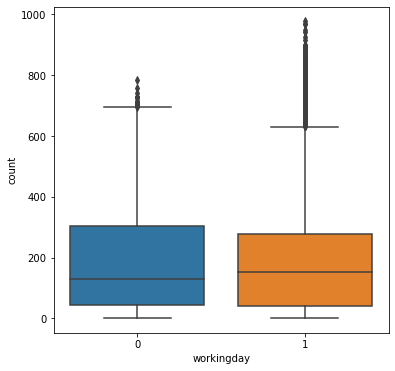

In [66]:
draw(sns.barplot, 'workingday','count')
draw(sns.boxplot, 'workingday','count')

In [67]:
tr_n.day_div.unique()

array(['weekend', 'workingday', 'holiday'], dtype=object)

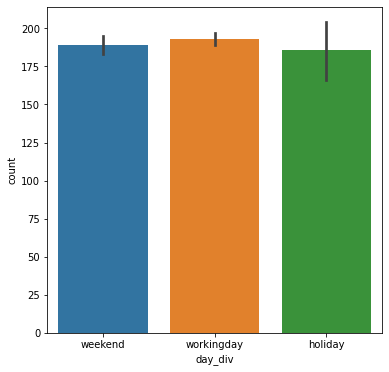

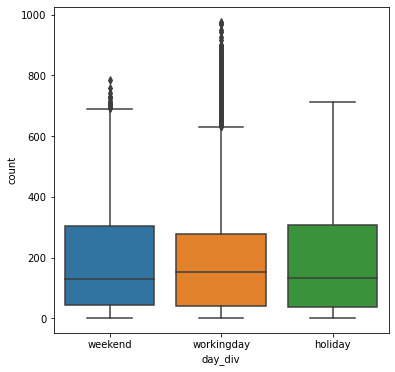

In [68]:
draw(sns.barplot, 'day_div','count',data=tr_n)
draw(sns.boxplot, 'day_div','count',data=tr_n)

- 휴일과 근무일은 시간변수와 함께 생각했을 때 더 유의미함. 단독으로는 의미가 없음

### Weather

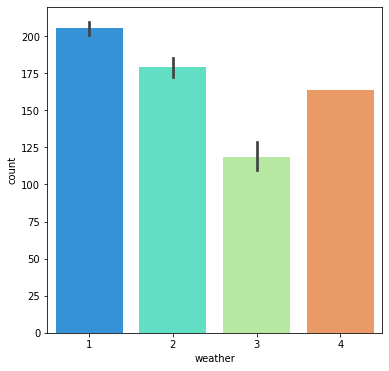

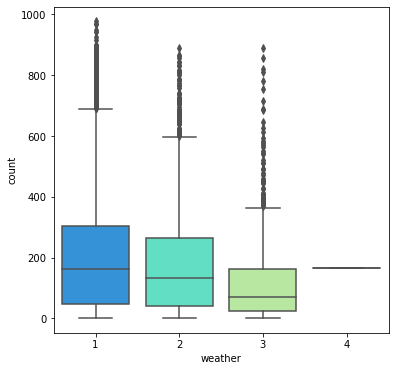

In [69]:
draw(sns.barplot,'weather','count',pal='rainbow')
draw(sns.boxplot,'weather','count',pal='rainbow')

- weather=4인 경우가 한 케이스밖에 없어서 결과가 다소 왜곡된 것으로 보임

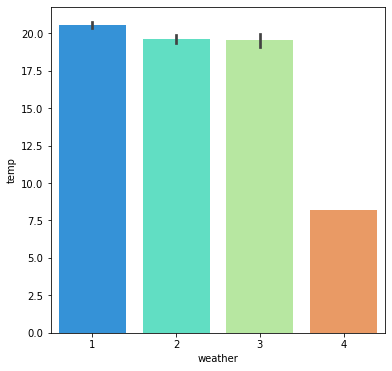

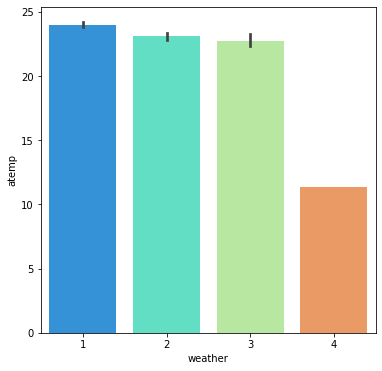

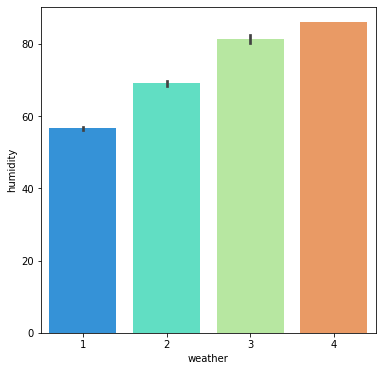

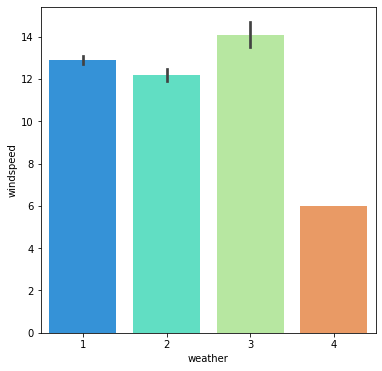

In [70]:
draw(sns.barplot,'weather','temp',pal='rainbow')
draw(sns.barplot,'weather','atemp',pal='rainbow')
draw(sns.barplot,'weather','humidity',pal='rainbow')
draw(sns.barplot,'weather','windspeed',pal='rainbow')

- weather은 유의미하나, 4인 경우의 케이스가 하나밖에 없어서 학습에는 영향이 어떨지?
- 테스트 데이터에는 weather=4인 케이스가 2케이스 존재

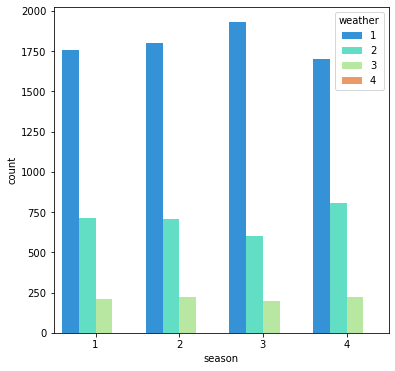

In [71]:
draw(sns.countplot,x='season',hue='weather',pal='rainbow')

### Temp & Atemp

<AxesSubplot:ylabel='atemp'>

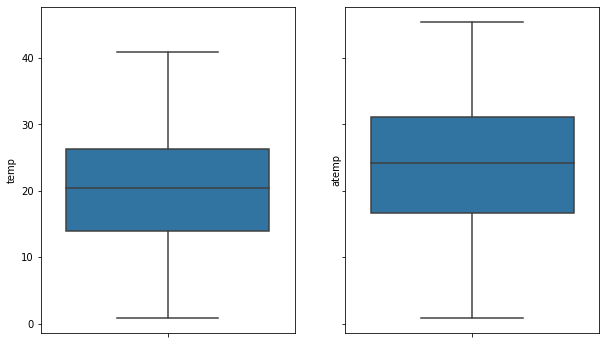

In [72]:
f, ax = plt.subplots(figsize=(10,6),sharey=True,ncols=2)
sns.boxplot(y='temp',orient='v',ax=ax[0],data=tr_n)
sns.boxplot(y='atemp',orient='v',ax=ax[1],data=tr_n)

<AxesSubplot:xlabel='atemp', ylabel='Count'>

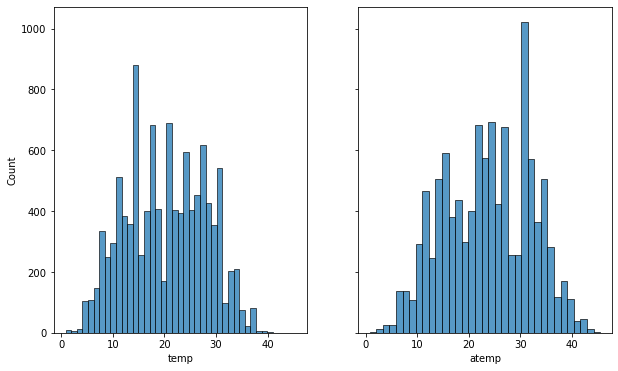

In [73]:
f, ax = plt.subplots(figsize=(10,6),sharey=True,sharex=True,ncols=2)
sns.histplot(x='temp',ax=ax[0],data=tr_n)
sns.histplot(x='atemp',ax=ax[1],data=tr_n)

In [74]:
tr_n.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [75]:
tr_n.atemp.describe()

count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64

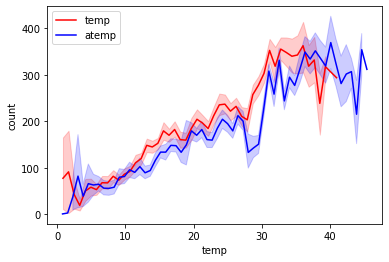

In [101]:
plt.figure()
sns.lineplot(x='temp',y='count',data=tr_n,label='temp',color='red')
sns.lineplot(x='atemp',y='count',data=tr_n,label='atemp',color='blue')
a = plt.legend()

In [108]:
import matplotlib

In [109]:
matplotlib.lines.Line2D

matplotlib.lines.Line2D

In [104]:
a.__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <AxesSubplot:xlabel='temp', ylabel='count'>,
 'figure': <Figure size 432x288 with 1 Axes>,
 '_transform': <matplotlib.transforms.IdentityTransform at 0x15a732a59d0>,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <bound method Axes._remove_legend of <AxesSubplot:xlabel='temp', ylabel='count'>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'prop': <matplotlib.font_manager.FontProperties at 0x15a732a53a0>,
 '_fontsize': 10.0,
 'texts': [Text(0, 0, 'temp'), Text(0, 0, 'atemp')],
 'legendHandles': [<matp

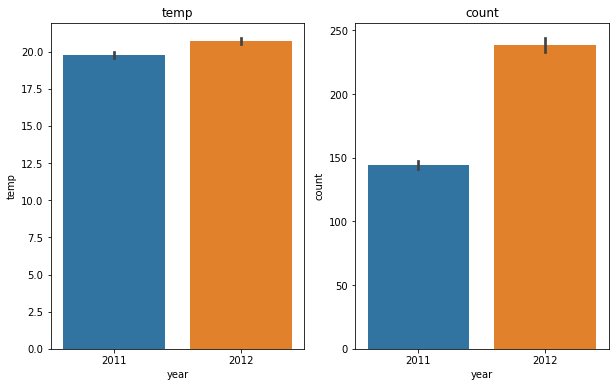

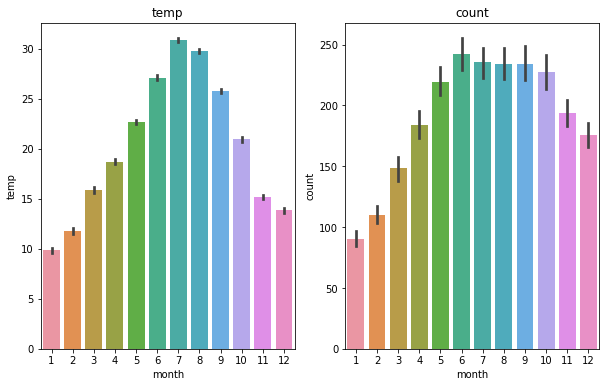

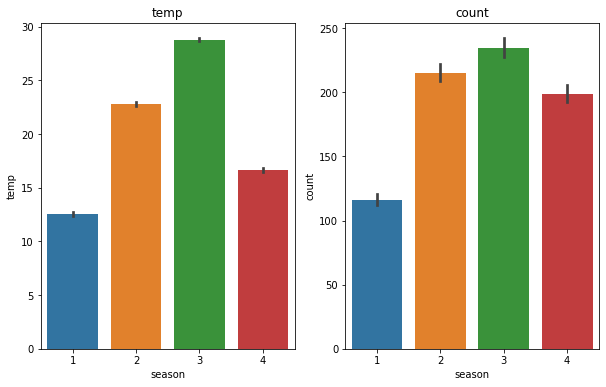

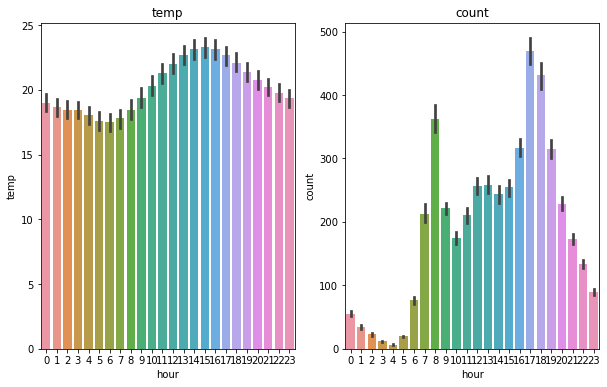

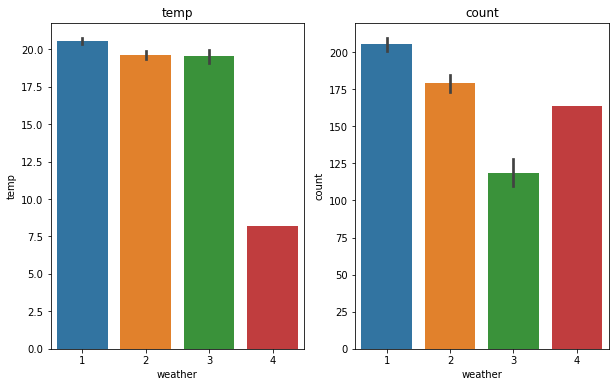

In [77]:
for x in ['year','month','season','hour','weather']:
    f, ax = plt.subplots(figsize=(10,6),ncols=2)
    sns.barplot(x=x,y='temp',data=tr_n,ax=ax[0])
    sns.barplot(x=x,y='count',data=tr_n,ax=ax[1])
    ax[0].set_title('temp')
    ax[1].set_title('count')
    plt.show()

- 온도와 계절의 경향성이 유사함. 성범님 아이디어대로 온도를 기준으로 계절을 나누는 건 좋아보임
- 온도와 대여 간의 상관성 존재

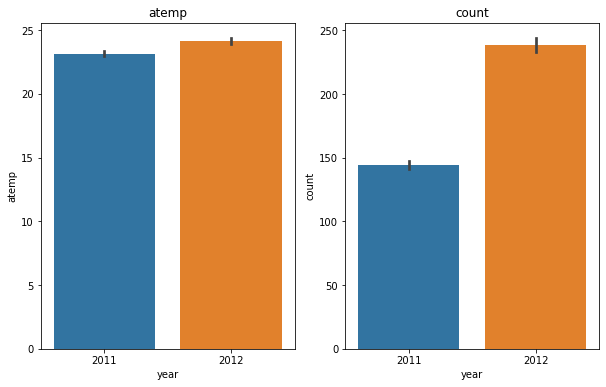

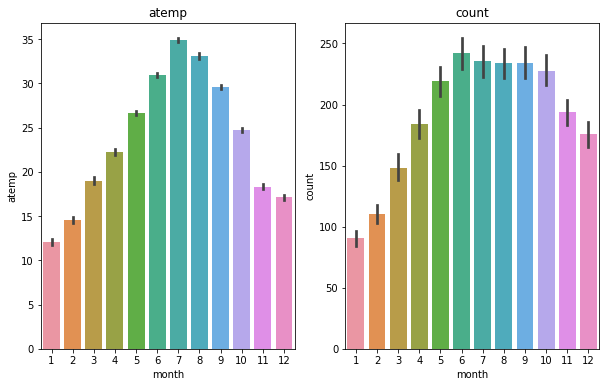

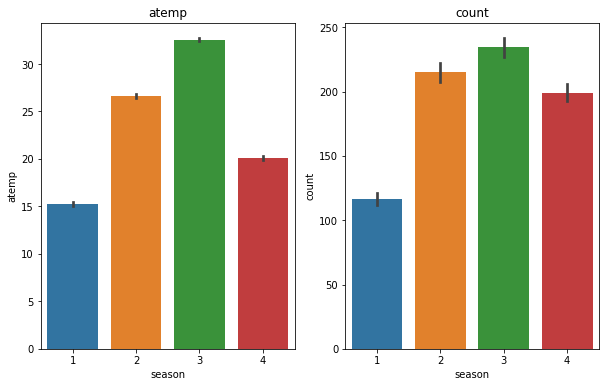

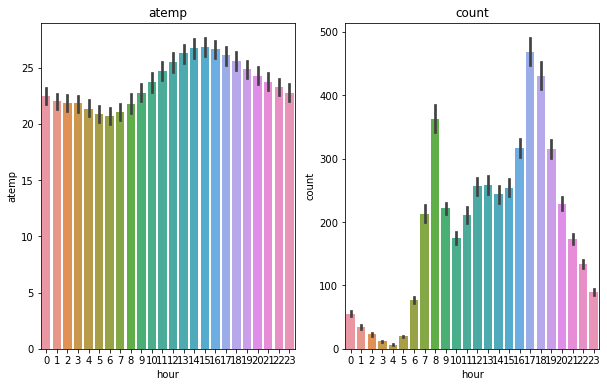

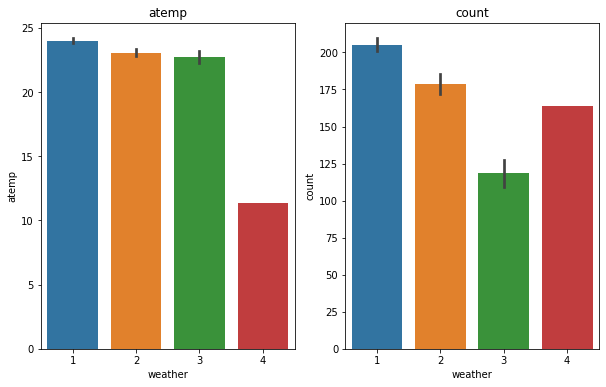

In [78]:
for x in ['year','month','season','hour','weather']:
    f, ax = plt.subplots(figsize=(10,6),ncols=2)
    sns.barplot(x=x,y='atemp',data=tr_n,ax=ax[0])
    sns.barplot(x=x,y='count',data=tr_n,ax=ax[1])
    ax[0].set_title('atemp')
    ax[1].set_title('count')
    plt.show()

In [79]:
tr_n['temp_diff']=tr_n.atemp-tr_n.temp

<AxesSubplot:xlabel='temp_diff', ylabel='humidity'>

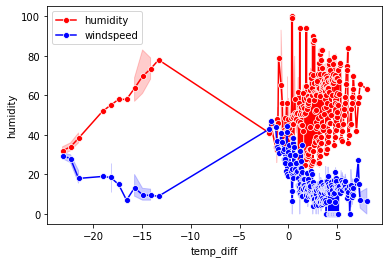

In [80]:
sns.lineplot(x='temp_diff',y='humidity',data=tr_n,label='humidity',color='red',marker='o')
sns.lineplot(x='temp_diff',y='windspeed',data=tr_n,label='windspeed',color='blue',marker='o')

<AxesSubplot:xlabel='temp_diff', ylabel='humidity'>

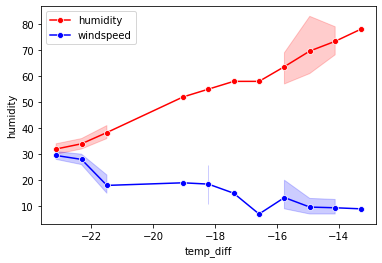

In [81]:
sns.lineplot(x='temp_diff',y='humidity',data=tr_n[tr_n.temp_diff<-5],label='humidity',color='red',marker='o')
sns.lineplot(x='temp_diff',y='windspeed',data=tr_n[tr_n.temp_diff<-5],label='windspeed',color='blue',marker='o')

### Humidity

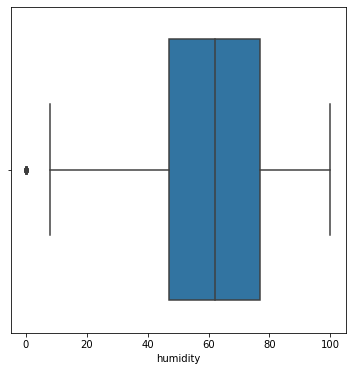

In [82]:
draw(sns.boxplot,'humidity')

In [83]:
tr_n.humidity.describe()

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64

In [84]:
print(tr_n[tr_n.humidity==0].date.unique())
print(tr_n[tr_n.humidity==0].hour.unique())
print(tr_n[tr_n.date=='2011-03-10'].hour.unique())

['2011-03-10']
[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


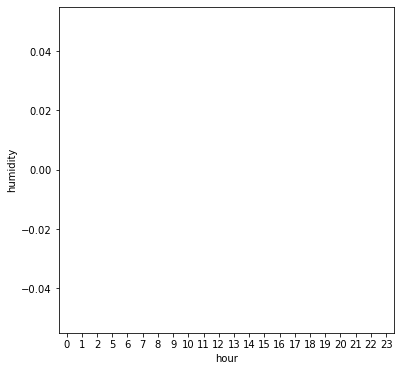

In [85]:
draw(sns.barplot,'hour','humidity',data=tr_n[tr_n.date=='2011-03-10'])

- 비가 오는 2011-03-10 하루종일 상대 습도가 0인것은 비상식적
- 대체할 수 있는 값: 03-10의 풍속, 온도, 체감온도, 날씨와 유사한 날의 상대습도

In [86]:
tr_n[tr_n.date=='2011-03-10'].head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,day_div,date,temp_diff
1091,2011-03-10 00:00:00,1,0,1,3,13.94,15.910,0,16.9979,3,2011,3,10,0,workingday,2011-03-10,1.970
1092,2011-03-10 01:00:00,1,0,1,3,13.94,15.910,0,16.9979,2,2011,3,10,1,workingday,2011-03-10,1.970
1093,2011-03-10 02:00:00,1,0,1,3,13.94,15.910,0,16.9979,1,2011,3,10,2,workingday,2011-03-10,1.970
1094,2011-03-10 05:00:00,1,0,1,3,14.76,17.425,0,12.9980,3,2011,3,10,5,workingday,2011-03-10,2.665
1095,2011-03-10 06:00:00,1,0,1,3,14.76,16.665,0,22.0028,12,2011,3,10,6,workingday,2011-03-10,1.905


In [87]:
tr_n[tr_n.date=='2011-03-10'][['temp','atemp','weather','windspeed']].mean()

temp         15.952727
atemp        19.283409
weather       2.909091
windspeed    17.545777
dtype: float64

In [88]:
#tr_n[(tr_n.month==3)&((tr_n.weather==3))][['day','temp','atemp','weather','windspeed']].groupby('day').mean()

tr_n[(tr_n.month==3)&((tr_n.weather==3))].to_csv('read.csv',index=False)

In [89]:
tr_n[tr_n.date=='2011-03-06'][['temp','atemp','weather','windspeed']].mean()

temp         15.437391
atemp        18.312609
weather       2.391304
windspeed    23.000226
dtype: float64

- 유사한 날씨의 2011-03-06의 상대 습도로 바꿔주는 것은 어떨까?

### WindSpeed

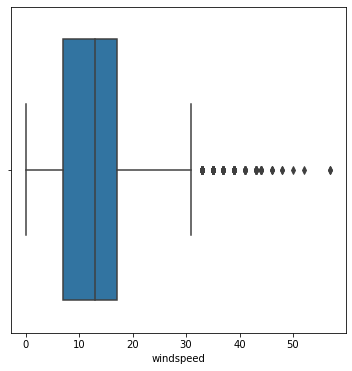

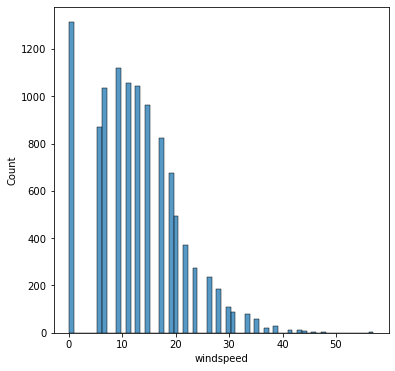

In [90]:
draw(sns.boxplot,'windspeed')
draw(sns.histplot,'windspeed')

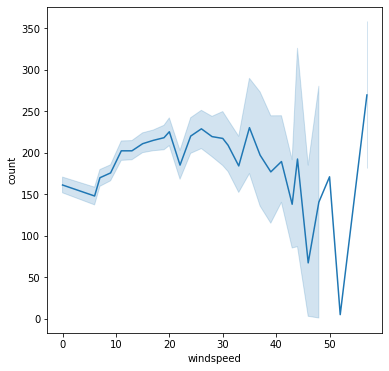

In [91]:
draw(sns.lineplot,'windspeed','count')

In [92]:
tr_n[tr_n.windspeed==0].date.unique()

array(['2011-01-01', '2011-01-03', '2011-01-04', '2011-01-05',
       '2011-01-06', '2011-01-07', '2011-01-08', '2011-01-11',
       '2011-01-14', '2011-01-15', '2011-01-16', '2011-01-18',
       '2011-01-19', '2011-02-01', '2011-02-02', '2011-02-03',
       '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07',
       '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11',
       '2011-02-12', '2011-02-13', '2011-02-15', '2011-03-01',
       '2011-03-02', '2011-03-03', '2011-03-07', '2011-03-08',
       '2011-03-12', '2011-03-13', '2011-03-14', '2011-03-15',
       '2011-03-16', '2011-04-01', '2011-04-02', '2011-04-03',
       '2011-04-07', '2011-04-08', '2011-04-09', '2011-04-10',
       '2011-04-11', '2011-04-14', '2011-04-15', '2011-04-16',
       '2011-04-18', '2011-04-19', '2011-05-01', '2011-05-02',
       '2011-05-06', '2011-05-07', '2011-05-08', '2011-05-09',
       '2011-05-10', '2011-05-11', '2011-05-12', '2011-05-14',
       '2011-05-15', '2011-05-16', '2011-05-17', '2011-

## One-hot encoding
- 카테고리형 데이터 모두 원-핫 인코딩



In [ ]:
tr_n = pd.get_dummies(tr_n, columns = ['year','month','day','hour','holiday','workingday','season','weather'])

In [ ]:
import numpy as np
x = np.array([1,2,3,4,5])
print(x[:-1])
print(x[1:])
np.array(x)[:-1] * np.array(x)[1:]
#(((np.array(x)[:-1] * np.array(x)[1:]) < 0).sum())/len(x)
